In [3]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetupProvinces import ItalySetupProvinces
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle, scipy
import tqdm

mpl.rc('text', usetex=True)
mpl.rc('font', size=8)
mpl.rc('legend', fontsize=7)

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
n_int_steps = 6
ocp = None

baseline = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 90

setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = setup.ndays - 1

outdir = 'model_output/'
prefix = 'beta-analysis'


Loaded Italy Setup with 107 nodes.


## Help build the scenarios by iterating over posterior realization and beta modifiers (and also compare with matlab)

In [32]:
import scipy.io
scipy.io.savemat('beta_multipliers.mat', courses)

In [26]:

courses = {}
course = scipy.interpolate.interp1d([0, 10, 40, 80, 100, 1000], [1, 1.5, .9, 1.3, 1.2, 1.2], kind='linear')
courses['U'] = course(np.arange(0, setup.ndays))
#course = scipy.interpolate.interp1d([0, 50, 100, 1000],[1, 1, 1, 1], kind='linear')# [.85, .85, .75, .85], kind='linear')  #([.75, .85, .75, .75])
#courses['C'] = course(np.arange(0, setup.ndays))
course = scipy.interpolate.interp1d([0, 10, 40, 80, 100, 1000], [1, .8, 1.1,.8, 1.5, .75], kind='linear')
courses['L'] = course(np.arange(0, setup.ndays))

cbs = ['U',  'L']
postdraws = [102]
all_res = {}
for cb in cbs:
    for postdraw in postdraws:
        real_course = np.ones((setup.nnodes, setup.ndays)) * courses[cb]
        p = COVIDParametersOCP.OCParameters(setup=setup, M=M, when=when, posterior_draw = postdraw)
        p.apply_epicourse(setup, real_course)
#    plt.figure()
#    plt.plot(real_course[0,:])

        control_initial = np.zeros((M, N))

        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{prefix}-int-{nnodes}_{ndays}-nc',
                                                                      method='rk4',
                                                                      n_rk4_steps=n_int_steps)
        all_res[f'{postdraw}{cb}'] = results[results['comp']=='I'].pivot(values = 'value', columns = 'place', index = 'date')
     

  2%|▏         | 2/89 [00:00<00:04, 17.68it/s]

nnz before: 4088, after: 528
===> Integrating for model_output/beta-analysis-int-107_90-nc


  2%|▏         | 2/89 [00:00<00:04, 18.00it/s]

nnz before: 4088, after: 528
===> Integrating for model_output/beta-analysis-int-107_90-nc


100%|██████████| 89/89 [00:04<00:00, 20.64it/s]


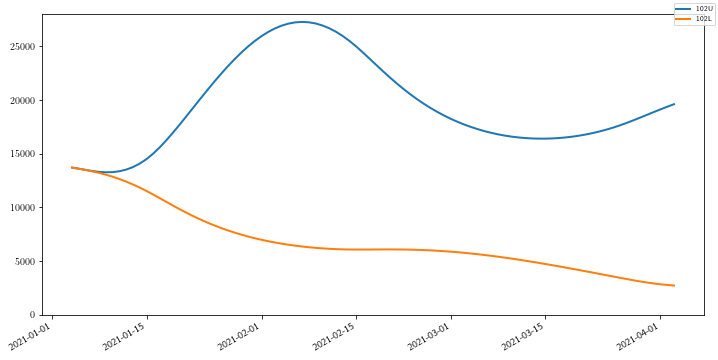

In [27]:
fig, ax = plt.subplots(1,1, figsize = (10,5), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

for cb in ['U','L']:#cbs):
    for postdraw in postdraws:
        ax.plot(all_res[f'{postdraw}{cb}'].sum(axis=1), linestyle='-', lw = 2, label = f'{postdraw}{cb}')#,c = colors[postdraw])

    ax.set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()
fig.legend()

In [145]:
colors = {34:'r', 92:'b', 96:'g', 65:'orange'}

[34, 96]

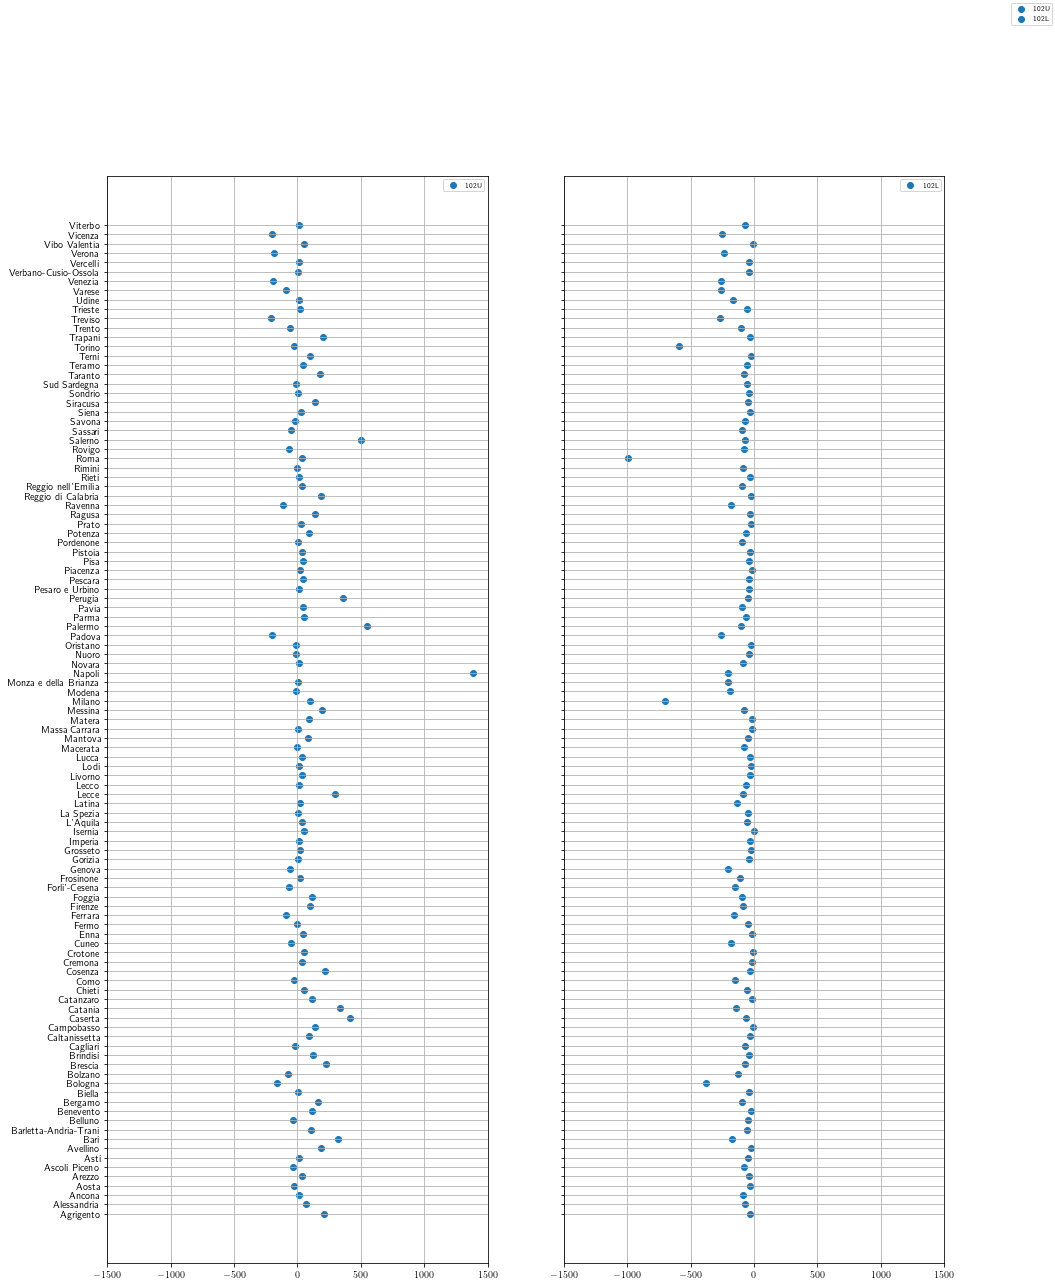

In [32]:
fig, axes = plt.subplots(1,2, figsize = (15,20), sharey=True, facecolor = 'white')#, sharey=True)
import seaborn as sns

for i, cb in enumerate(cbs):
    for j, postdraw in enumerate(postdraws):
        axes.flat[i].scatter(
                   all_res[f'{postdraw}{cb}'].iloc[-1] - all_res[f'{postdraw}{cb}'].iloc[0], 
            all_res[f'{postdraw}{cb}'].columns,
                marker = 'o',
                label = f'{postdraw}{cb}',
               #c = colors[postdraw],
                   #alpha = .5
                  )
        axes.flat[i].set_xlim(-1500,1500)
        axes.flat[i].legend()
        axes.flat[i].grid(True)

#plt.xticks( rotation='vertical')
#ax.set_yscale('log')
#fig.autofmt_xdate()
fig.legend();

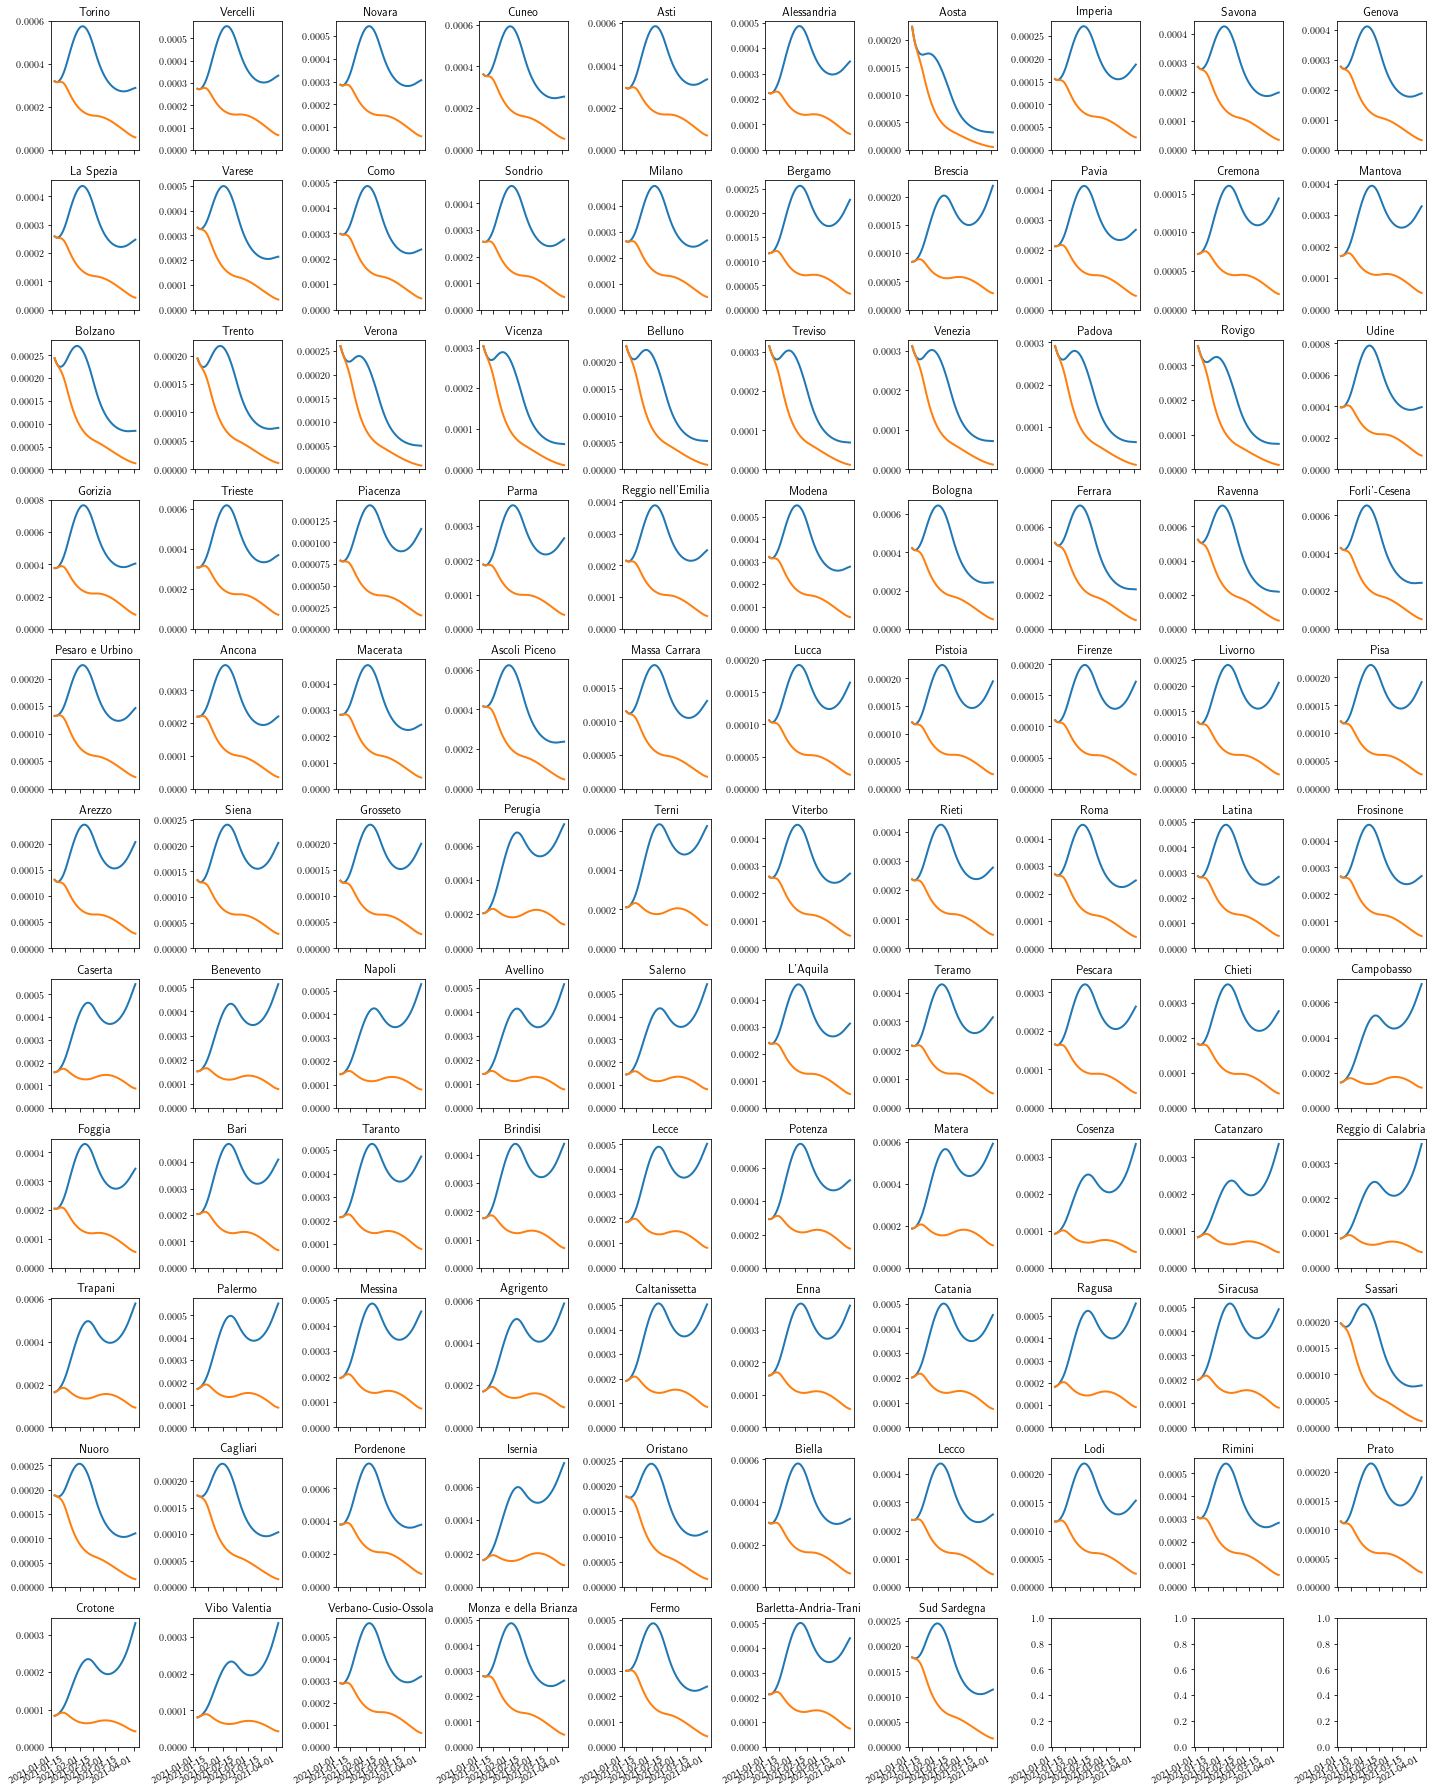

In [28]:
fig, axes = plt.subplots(11,10, figsize = (20,25), sharex=True, facecolor = 'white')#, sharey=True)
import seaborn as sns
for k, nname in enumerate(setup.ind2name):
    for cb in cbs:
        for postdraw in postdraws:
            axes.flat[k].plot(all_res[f'{postdraw}{cb}'][nname]/setup.pop_node[k], linestyle='-', lw = 2)#, c = colors[postdraw])
    #axes.flat[k].plot(p.matlab_model_days, p.matlab_initial[k,:,3], linestyle='-', lw = 1, color='k')

    axes.flat[k].set_title(nname);
    axes.flat[k].set_ylim(0);
fig.autofmt_xdate()
fig.tight_layout()

nnz before: 4088, after: 528


nnz before: 4088, after: 528


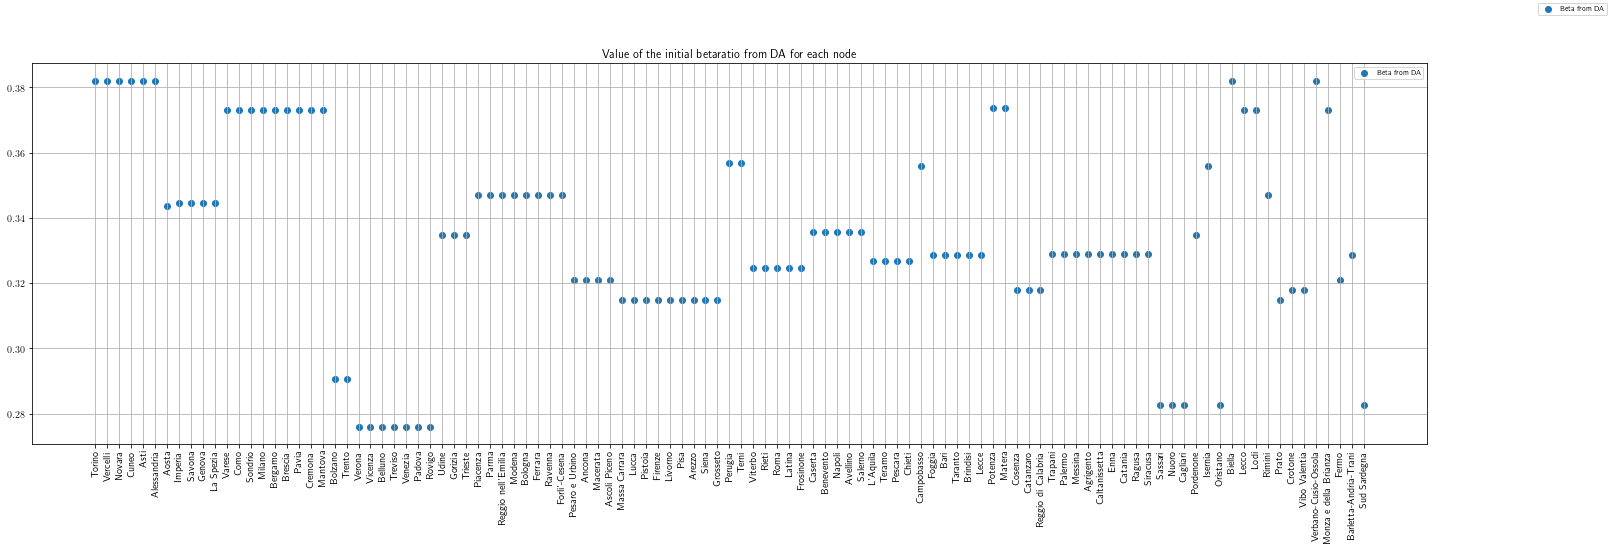

In [25]:

fig, axes = plt.subplots(1,1, figsize = (25,7),  facecolor = 'white')#, sharey=True)
import seaborn as sns

p = COVIDParametersOCP.OCParameters(setup=setup, M=M, when=when, posterior_draw = 102)

axes.scatter(setup.ind2name,p.beta_ratio,
        marker = 'o',
        label = f'Beta from DA',
       #c = colors[postdraw],
           #alpha = .5
          )
axes.legend()
axes.grid(True)
axes.set_title('Value of the initial betaratio from DA for each node')

plt.xticks( rotation='vertical')
#ax.set_yscale('log')
#fig.autofmt_xdate()
fig.legend();
plt.savefig('figures/beta_from_DA.pdf')

In [9]:
pick_scenario(setup=setup, scn_id=1)

{'name': 'L-r15-t125000-id1',
 'newdoseperweek': 125000,
 'rate_fomula': '(0.008283696183248878*pop_nd)',
 'beta_mult': array([[0.65 , 0.653, 0.656, ..., 0.467, 0.458, 0.449],
        [0.65 , 0.653, 0.656, ..., 0.467, 0.458, 0.449],
        [0.65 , 0.653, 0.656, ..., 0.467, 0.458, 0.449],
        ...,
        [0.65 , 0.653, 0.656, ..., 0.467, 0.458, 0.449],
        [0.65 , 0.653, 0.656, ..., 0.467, 0.458, 0.449],
        [0.65 , 0.653, 0.656, ..., 0.467, 0.458, 0.449]])}

# Compare scenarios in a paper figure

In [2]:
for dr in tqdm.tqdm(range(102)):
    p = COVIDParametersOCP.OCParameters(setup=setup, M=M, when=when, posterior_draw=dr+1)
    with open(f'model_output/beta-posteriors/beta{dr+1}.pkl', 'wb') as out:
        pickle.dump(p, out, pickle.HIGHEST_PROTOCOL)

  1%|          | 1/102 [00:08<13:47,  8.19s/it]

nnz before: 4088, after: 528


  2%|▏         | 2/102 [00:15<13:07,  7.88s/it]

nnz before: 4088, after: 528


  3%|▎         | 3/102 [00:22<12:33,  7.61s/it]

nnz before: 4088, after: 528


  4%|▍         | 4/102 [00:29<12:04,  7.39s/it]

nnz before: 4088, after: 528


  5%|▍         | 5/102 [00:35<11:39,  7.21s/it]

nnz before: 4088, after: 528


  6%|▌         | 6/102 [00:42<11:16,  7.04s/it]

nnz before: 4088, after: 528


  7%|▋         | 7/102 [00:49<11:03,  6.99s/it]

nnz before: 4088, after: 528


  8%|▊         | 8/102 [00:56<11:02,  7.05s/it]

nnz before: 4088, after: 528


  9%|▉         | 9/102 [01:03<10:53,  7.03s/it]

nnz before: 4088, after: 528


 10%|▉         | 10/102 [01:10<10:49,  7.06s/it]

nnz before: 4088, after: 528


 11%|█         | 11/102 [01:17<10:44,  7.09s/it]

nnz before: 4088, after: 528


 12%|█▏        | 12/102 [01:24<10:33,  7.04s/it]

nnz before: 4088, after: 528


 13%|█▎        | 13/102 [01:32<10:29,  7.08s/it]

nnz before: 4088, after: 528


 14%|█▎        | 14/102 [01:39<10:23,  7.09s/it]

nnz before: 4088, after: 528


 15%|█▍        | 15/102 [01:46<10:17,  7.10s/it]

nnz before: 4088, after: 528


 16%|█▌        | 16/102 [01:53<10:19,  7.20s/it]

nnz before: 4088, after: 528


 17%|█▋        | 17/102 [02:01<10:15,  7.24s/it]

nnz before: 4088, after: 528


 18%|█▊        | 18/102 [02:08<10:05,  7.21s/it]

nnz before: 4088, after: 528


 19%|█▊        | 19/102 [02:15<10:02,  7.26s/it]

nnz before: 4088, after: 528


 20%|█▉        | 20/102 [02:22<09:48,  7.18s/it]

nnz before: 4088, after: 528


 21%|██        | 21/102 [02:29<09:37,  7.12s/it]

nnz before: 4088, after: 528


 22%|██▏       | 22/102 [02:36<09:36,  7.21s/it]

nnz before: 4088, after: 528


 23%|██▎       | 23/102 [02:44<09:29,  7.21s/it]

nnz before: 4088, after: 528


 24%|██▎       | 24/102 [02:51<09:27,  7.27s/it]

nnz before: 4088, after: 528


 25%|██▍       | 25/102 [02:58<09:22,  7.31s/it]

nnz before: 4088, after: 528


 25%|██▌       | 26/102 [03:06<09:13,  7.29s/it]

nnz before: 4088, after: 528


 26%|██▋       | 27/102 [03:13<08:58,  7.17s/it]

nnz before: 4088, after: 528


 27%|██▋       | 28/102 [03:20<08:52,  7.20s/it]

nnz before: 4088, after: 528


 28%|██▊       | 29/102 [03:27<08:48,  7.24s/it]

nnz before: 4088, after: 528


 29%|██▉       | 30/102 [03:34<08:37,  7.19s/it]

nnz before: 4088, after: 528


 30%|███       | 31/102 [03:41<08:30,  7.19s/it]

nnz before: 4088, after: 528


 31%|███▏      | 32/102 [03:49<08:20,  7.15s/it]

nnz before: 4088, after: 528


 32%|███▏      | 33/102 [03:56<08:22,  7.29s/it]

nnz before: 4088, after: 528


 33%|███▎      | 34/102 [04:04<08:22,  7.39s/it]

nnz before: 4088, after: 528


 34%|███▍      | 35/102 [04:11<08:10,  7.32s/it]

nnz before: 4088, after: 528


 35%|███▌      | 36/102 [04:18<07:59,  7.26s/it]

nnz before: 4088, after: 528


 36%|███▋      | 37/102 [04:25<07:48,  7.20s/it]

nnz before: 4088, after: 528


 37%|███▋      | 38/102 [04:33<07:54,  7.41s/it]

nnz before: 4088, after: 528


 38%|███▊      | 39/102 [04:40<07:41,  7.33s/it]

nnz before: 4088, after: 528


 39%|███▉      | 40/102 [04:47<07:24,  7.17s/it]

nnz before: 4088, after: 528


 40%|████      | 41/102 [04:54<07:08,  7.02s/it]

nnz before: 4088, after: 528


 41%|████      | 42/102 [05:01<06:59,  7.00s/it]

nnz before: 4088, after: 528


 42%|████▏     | 43/102 [05:07<06:49,  6.94s/it]

nnz before: 4088, after: 528


 43%|████▎     | 44/102 [05:14<06:41,  6.93s/it]

nnz before: 4088, after: 528


 44%|████▍     | 45/102 [05:22<06:42,  7.06s/it]

nnz before: 4088, after: 528


 45%|████▌     | 46/102 [05:29<06:39,  7.14s/it]

nnz before: 4088, after: 528


 46%|████▌     | 47/102 [05:36<06:30,  7.10s/it]

nnz before: 4088, after: 528


 47%|████▋     | 48/102 [05:43<06:23,  7.09s/it]

nnz before: 4088, after: 528


 48%|████▊     | 49/102 [05:50<06:15,  7.09s/it]

nnz before: 4088, after: 528


 49%|████▉     | 50/102 [05:57<06:03,  6.99s/it]

nnz before: 4088, after: 528


 50%|█████     | 51/102 [06:04<05:56,  6.99s/it]

nnz before: 4088, after: 528


 51%|█████     | 52/102 [06:11<05:51,  7.02s/it]

nnz before: 4088, after: 528


 52%|█████▏    | 53/102 [06:18<05:43,  7.01s/it]

nnz before: 4088, after: 528


 53%|█████▎    | 54/102 [06:26<05:45,  7.20s/it]

nnz before: 4088, after: 528


 54%|█████▍    | 55/102 [06:33<05:35,  7.14s/it]

nnz before: 4088, after: 528


 55%|█████▍    | 56/102 [06:40<05:31,  7.20s/it]

nnz before: 4088, after: 528


 56%|█████▌    | 57/102 [06:47<05:20,  7.13s/it]

nnz before: 4088, after: 528


 57%|█████▋    | 58/102 [06:54<05:07,  6.99s/it]

nnz before: 4088, after: 528


 58%|█████▊    | 59/102 [07:01<05:08,  7.18s/it]

nnz before: 4088, after: 528


 59%|█████▉    | 60/102 [07:08<05:02,  7.21s/it]

nnz before: 4088, after: 528


 60%|█████▉    | 61/102 [07:16<04:55,  7.20s/it]

nnz before: 4088, after: 528


 61%|██████    | 62/102 [07:23<04:48,  7.22s/it]

nnz before: 4088, after: 528


 62%|██████▏   | 63/102 [07:30<04:41,  7.22s/it]

nnz before: 4088, after: 528


 63%|██████▎   | 64/102 [07:38<04:39,  7.36s/it]

nnz before: 4088, after: 528


 64%|██████▎   | 65/102 [07:45<04:29,  7.28s/it]

nnz before: 4088, after: 528


 65%|██████▍   | 66/102 [07:52<04:20,  7.23s/it]

nnz before: 4088, after: 528


 66%|██████▌   | 67/102 [07:59<04:12,  7.21s/it]

nnz before: 4088, after: 528


 67%|██████▋   | 68/102 [08:06<04:05,  7.21s/it]

nnz before: 4088, after: 528


 68%|██████▊   | 69/102 [08:14<03:56,  7.18s/it]

nnz before: 4088, after: 528


 69%|██████▊   | 70/102 [08:21<03:48,  7.13s/it]

nnz before: 4088, after: 528


 70%|██████▉   | 71/102 [08:28<03:41,  7.13s/it]

nnz before: 4088, after: 528


 71%|███████   | 72/102 [08:35<03:35,  7.18s/it]

nnz before: 4088, after: 528


 72%|███████▏  | 73/102 [08:42<03:27,  7.15s/it]

nnz before: 4088, after: 528


 73%|███████▎  | 74/102 [08:49<03:18,  7.10s/it]

nnz before: 4088, after: 528


 74%|███████▎  | 75/102 [08:56<03:13,  7.16s/it]

nnz before: 4088, after: 528


 75%|███████▍  | 76/102 [09:04<03:09,  7.29s/it]

nnz before: 4088, after: 528


 75%|███████▌  | 77/102 [09:11<03:01,  7.26s/it]

nnz before: 4088, after: 528


 76%|███████▋  | 78/102 [09:18<02:52,  7.21s/it]

nnz before: 4088, after: 528


 77%|███████▋  | 79/102 [09:25<02:45,  7.21s/it]

nnz before: 4088, after: 528


 78%|███████▊  | 80/102 [09:33<02:38,  7.22s/it]

nnz before: 4088, after: 528


 79%|███████▉  | 81/102 [09:40<02:31,  7.23s/it]

nnz before: 4088, after: 528


 80%|████████  | 82/102 [09:47<02:26,  7.33s/it]

nnz before: 4088, after: 528


 81%|████████▏ | 83/102 [09:55<02:21,  7.42s/it]

nnz before: 4088, after: 528


 82%|████████▏ | 84/102 [10:03<02:15,  7.52s/it]

nnz before: 4088, after: 528


 83%|████████▎ | 85/102 [10:10<02:07,  7.51s/it]

nnz before: 4088, after: 528


 84%|████████▍ | 86/102 [10:18<02:00,  7.51s/it]

nnz before: 4088, after: 528


 85%|████████▌ | 87/102 [10:25<01:50,  7.35s/it]

nnz before: 4088, after: 528


 86%|████████▋ | 88/102 [10:32<01:41,  7.24s/it]

nnz before: 4088, after: 528


 87%|████████▋ | 89/102 [10:39<01:34,  7.24s/it]

nnz before: 4088, after: 528


 88%|████████▊ | 90/102 [10:46<01:26,  7.21s/it]

nnz before: 4088, after: 528


 89%|████████▉ | 91/102 [10:54<01:19,  7.24s/it]

nnz before: 4088, after: 528


 90%|█████████ | 92/102 [11:02<01:14,  7.49s/it]

nnz before: 4088, after: 528


 91%|█████████ | 93/102 [11:10<01:09,  7.72s/it]

nnz before: 4088, after: 528


 92%|█████████▏| 94/102 [11:17<01:01,  7.70s/it]

nnz before: 4088, after: 528


 93%|█████████▎| 95/102 [11:25<00:52,  7.57s/it]

nnz before: 4088, after: 528


 94%|█████████▍| 96/102 [11:32<00:44,  7.48s/it]

nnz before: 4088, after: 528


 95%|█████████▌| 97/102 [11:40<00:38,  7.74s/it]

nnz before: 4088, after: 528


 96%|█████████▌| 98/102 [11:49<00:31,  7.88s/it]

nnz before: 4088, after: 528


 97%|█████████▋| 99/102 [11:57<00:23,  7.94s/it]

nnz before: 4088, after: 528


 98%|█████████▊| 100/102 [12:05<00:15,  7.99s/it]

nnz before: 4088, after: 528


 99%|█████████▉| 101/102 [12:13<00:08,  8.04s/it]

nnz before: 4088, after: 528


100%|██████████| 102/102 [12:21<00:00,  7.27s/it]

nnz before: 4088, after: 528


In [4]:
def runall(dr, scenario_mu, name):
    with open(f'model_output/beta-posteriors/beta{dr+1}.pkl', 'rb') as inp:
        p = pickle.load(inp)
    p.apply_epicourse(setup, scenario_mu)
    control_initial = np.zeros((M, N))
    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/beta-posteriors/bet_sim{dr+1}_{name}',
                                                                      method='rk4',
                                                                      n_rk4_steps=n_int_steps)
    return results

In [5]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
import pickle

beta_scenarios = ['U', 'L']   # thankfully 0 and 1 are U and L respecetively. But ugly

all_sims = {}


for i, beta_scn in enumerate(beta_scenarios):
    all_sims[beta_scn]= []

    scenario = pick_scenario(setup=setup, scn_id=i)
    print(i, scenario['name'])
    #for dr in range(100):
    #    runall(dr, scenario['beta_mult'], scenario['name'])
    
    all_sims[beta_scn] = pool.starmap(runall, [(dr, scenario['beta_mult'], scenario['name']) for dr in range(102)])

===> Integrating for model_output/beta-posteriors/bet_sim1_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim3_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim5_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim7_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim9_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim11_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim13_U-r3-t479700-id0

===> Integrating for model_output/beta-posteriors/bet_sim17_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim21_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim15_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim19_U-r3-t479700-id0



===> Integrating for model_output/beta-posteriors/bet_sim23_U-r3-t479700-id0
===> Integrating for model_output/beta-posteriors/bet_sim25_U-r3-t479700-id0===> Integ

  0%|          | 0/89 [00:00<?, ?it/s]

  1%|          | 1/89 [00:00<00:11,  7.75it/s]

0 U-r3-t479700-id0


100%|██████████| 89/89 [00:13<00:00,  6.51it/s]

100%|██████████| 89/89 [00:13<00:00,  6.49it/s]

100%|██████████| 89/89 [00:13<00:00,  6.48it/s]

100%|██████████| 89/89 [00:13<00:00,  6.44it/s]


===> Integrating for model_output/beta-posteriors/bet_sim14_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:11,  7.39it/s]

===> Integrating for model_output/beta-posteriors/bet_sim26_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim22_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s].10it/s]

===> Integrating for model_output/beta-posteriors/bet_sim4_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim30_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim18_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim16_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim8_U-r3-t479700-id0

===> Integrating for model_output/beta-posteriors/bet_sim24_U-r3-t479700-id0

  0%|          | 0/89 [00:00<?, ?it/s]


===> Integrating for model_output/beta-posteriors/bet_sim2_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim32_U-r3-t479700-id0



  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim10_U-r3-t479700-id0
===> Integrating for model_output/beta-posteriors/bet_sim6_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim12_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:13,  6.37it/s]

===> Integrating for model_output/beta-posteriors/bet_sim28_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:14,  6.14it/s]

===> Integrating for model_output/beta-posteriors/bet_sim20_U-r3-t479700-id0


100%|██████████| 89/89 [00:14<00:00,  6.07it/s]

100%|██████████| 89/89 [00:14<00:00,  6.03it/s]


===> Integrating for model_output/beta-posteriors/bet_sim33_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:13,  6.69it/s]

===> Integrating for model_output/beta-posteriors/bet_sim35_U-r3-t479700-id0


  2%|▏         | 2/89 [00:00<00:12,  6.86it/s]

===> Integrating for model_output/beta-posteriors/bet_sim37_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim39_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:15,  5.56it/s]

===> Integrating for model_output/beta-posteriors/bet_sim41_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim43_U-r3-t479700-id0


  6%|▌         | 5/89 [00:00<00:14,  5.95it/s]

===> Integrating for model_output/beta-posteriors/bet_sim45_U-r3-t479700-id0


  4%|▍         | 4/89 [00:00<00:13,  6.21it/s]

===> Integrating for model_output/beta-posteriors/bet_sim47_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:09,  9.52it/s]

===> Integrating for model_output/beta-posteriors/bet_sim49_U-r3-t479700-id0


  6%|▌         | 5/89 [00:00<00:12,  6.80it/s]

===> Integrating for model_output/beta-posteriors/bet_sim51_U-r3-t479700-id0


  8%|▊         | 7/89 [00:01<00:12,  6.78it/s]

===> Integrating for model_output/beta-posteriors/bet_sim53_U-r3-t479700-id0

  2%|▏         | 2/89 [00:00<00:09,  8.75it/s]

  7%|▋         | 6/89 [00:00<00:12,  6.75it/s]

===> Integrating for model_output/beta-posteriors/bet_sim55_U-r3-t479700-id0


  8%|▊         | 7/89 [00:01<00:12,  6.76it/s]

===> Integrating for model_output/beta-posteriors/bet_sim57_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:11,  7.46it/s]

===> Integrating for model_output/beta-posteriors/bet_sim59_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:12,  6.71it/s]

===> Integrating for model_output/beta-posteriors/bet_sim61_U-r3-t479700-id0


  9%|▉         | 8/89 [00:01<00:12,  6.24it/s]

===> Integrating for model_output/beta-posteriors/bet_sim63_U-r3-t479700-id0


100%|██████████| 89/89 [00:19<00:00,  4.45it/s]


===> Integrating for model_output/beta-posteriors/bet_sim34_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:12,  6.87it/s]

===> Integrating for model_output/beta-posteriors/bet_sim36_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:14,  6.13it/s]

===> Integrating for model_output/beta-posteriors/bet_sim40_U-r3-t479700-id0


  6%|▌         | 5/89 [00:00<00:14,  5.78it/s]

===> Integrating for model_output/beta-posteriors/bet_sim42_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim38_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim44_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:15,  5.73it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim48_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:14,  5.87it/s]

===> Integrating for model_output/beta-posteriors/bet_sim52_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:14,  6.09it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim50_U-r3-t479700-id0===> Integrating for model_output/beta-posteriors/bet_sim56_U-r3-t479700-id0

  2%|▏         | 2/89 [00:00<00:14,  5.96it/s]

  9%|▉         | 8/89 [00:01<00:13,  5.82it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim46_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:14,  5.96it/s]

===> Integrating for model_output/beta-posteriors/bet_sim62_U-r3-t479700-id0

  1%|          | 1/89 [00:00<00:14,  6.17it/s]

 10%|█         | 9/89 [00:01<00:13,  5.83it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim60_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:14,  5.92it/s]

===> Integrating for model_output/beta-posteriors/bet_sim54_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:13,  6.34it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim58_U-r3-t479700-id0


  7%|▋         | 6/89 [00:01<00:14,  5.90it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim64_U-r3-t479700-id0


100%|██████████| 89/89 [00:16<00:00,  5.50it/s]


===> Integrating for model_output/beta-posteriors/bet_sim65_U-r3-t479700-id0


  8%|▊         | 7/89 [00:01<00:13,  5.89it/s]

===> Integrating for model_output/beta-posteriors/bet_sim67_U-r3-t479700-id0


  7%|▋         | 6/89 [00:00<00:13,  6.11it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim69_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:13,  6.63it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim71_U-r3-t479700-id0


 18%|█▊        | 16/89 [00:02<00:11,  6.20it/s]

===> Integrating for model_output/beta-posteriors/bet_sim73_U-r3-t479700-id0


 19%|█▉        | 17/89 [00:02<00:11,  6.09it/s]

===> Integrating for model_output/beta-posteriors/bet_sim75_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:13,  6.41it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim77_U-r3-t479700-id0


 20%|██        | 18/89 [00:02<00:11,  6.02it/s]

===> Integrating for model_output/beta-posteriors/bet_sim79_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:13,  6.75it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim81_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:14,  6.22it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim83_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim85_U-r3-t479700-id0


  2%|▏         | 2/89 [00:00<00:14,  6.17it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim87_U-r3-t479700-id0


  2%|▏         | 2/89 [00:00<00:14,  5.80it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim89_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:16,  5.33it/s]

===> Integrating for model_output/beta-posteriors/bet_sim91_U-r3-t479700-id0


  2%|▏         | 2/89 [00:00<00:15,  5.44it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim93_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:16,  5.20it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim95_U-r3-t479700-id0


100%|██████████| 89/89 [00:15<00:00,  5.59it/s]


===> Integrating for model_output/beta-posteriors/bet_sim66_U-r3-t479700-id0


 16%|█▌        | 14/89 [00:02<00:11,  6.68it/s]

===> Integrating for model_output/beta-posteriors/bet_sim68_U-r3-t479700-id0

 17%|█▋        | 15/89 [00:02<00:11,  6.53it/s]

  9%|▉         | 8/89 [00:01<00:12,  6.52it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim70_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:12,  7.25it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim72_U-r3-t479700-id0


  3%|▎         | 3/89 [00:00<00:14,  5.94it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim74_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim78_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:14,  6.01it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim76_U-r3-t479700-id0


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim80_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:15,  5.83it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim84_U-r3-t479700-id0


  1%|          | 1/89 [00:00<00:16,  5.48it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim82_U-r3-t479700-id0


 35%|███▍      | 31/89 [00:04<00:10,  5.42it/s]

===> Integrating for model_output/beta-posteriors/bet_sim92_U-r3-t479700-id0


 18%|█▊        | 16/89 [00:02<00:13,  5.46it/s]

===> Integrating for model_output/beta-posteriors/bet_sim90_U-r3-t479700-id0


  9%|▉         | 8/89 [00:01<00:15,  5.32it/s]

===> Integrating for model_output/beta-posteriors/bet_sim86_U-r3-t479700-id0


  2%|▏         | 2/89 [00:00<00:16,  5.15it/s]

===> Integrating for model_output/beta-posteriors/bet_sim88_U-r3-t479700-id0


  6%|▌         | 5/89 [00:00<00:16,  5.07it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim94_U-r3-t479700-id0


 10%|█         | 9/89 [00:01<00:15,  5.06it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim96_U-r3-t479700-id0

 11%|█         | 10/89 [00:01<00:16,  4.86it/s]

100%|██████████| 89/89 [00:16<00:00,  5.48it/s]


===> Integrating for model_output/beta-posteriors/bet_sim97_U-r3-t479700-id0


 27%|██▋       | 24/89 [00:03<00:09,  6.58it/s]

===> Integrating for model_output/beta-posteriors/bet_sim99_U-r3-t479700-id0


 12%|█▏        | 11/89 [00:01<00:10,  7.20it/s]

===> Integrating for model_output/beta-posteriors/bet_sim101_U-r3-t479700-id0

 13%|█▎        | 12/89 [00:01<00:10,  7.20it/s]

100%|██████████| 89/89 [00:06<00:00, 12.88it/s]


===> Integrating for model_output/beta-posteriors/bet_sim98_U-r3-t479700-id0


 29%|██▉       | 26/89 [00:01<00:03, 19.04it/s]

===> Integrating for model_output/beta-posteriors/bet_sim100_U-r3-t479700-id0


 11%|█         | 10/89 [00:00<00:04, 18.98it/s]

===> Integrating for model_output/beta-posteriors/bet_sim102_U-r3-t479700-id0

 43%|████▎     | 38/89 [00:01<00:02, 19.16it/s]

100%|██████████| 89/89 [00:04<00:00, 18.53it/s]


===> Integrating for model_output/beta-posteriors/bet_sim1_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim3_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim5_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim7_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim9_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim11_L-r3-t479700-id1
===> Integrating for model_output/beta-posteriors/bet_sim13_L-r3-t479700-id1
===> Integrating for model_output/beta-posteriors/bet_sim15_L-r3-t479700-id1
===> Integrating for model_output/beta-posteriors/bet_sim17_L-r3-t479700-id1
===> Integrating for model_output/beta-posteriors/bet_sim19_L-r3-t479700-id1





  0%|          | 0/89 [00:00<?, ?it/s]


===> Integrating for model_output/beta-posteriors/bet_sim21_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim23_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim27_L-r3-t479700-id1

  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim25_L-r3-t479700-id1

  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim29_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim31_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  1%|          | 1/89 [00:00<00:11,  7.57it/s]

1 L-r3-t479700-id1


100%|██████████| 89/89 [00:14<00:00,  6.01it/s]

100%|██████████| 89/89 [00:14<00:00,  5.98it/s]


===> Integrating for model_output/beta-posteriors/bet_sim28_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim2_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:12,  6.86it/s]

===> Integrating for model_output/beta-posteriors/bet_sim14_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim16_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim18_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim4_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim32_L-r3-t479700-id1



  1%|          | 1/89 [00:00<00:13,  6.38it/s]

===> Integrating for model_output/beta-posteriors/bet_sim20_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim22_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s].51it/s]

===> Integrating for model_output/beta-posteriors/bet_sim24_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:15,  5.78it/s]

===> Integrating for model_output/beta-posteriors/bet_sim26_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim8_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim12_L-r3-t479700-id1



  1%|          | 1/89 [00:00<00:14,  5.92it/s]

===> Integrating for model_output/beta-posteriors/bet_sim6_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  5.91it/s]

===> Integrating for model_output/beta-posteriors/bet_sim10_L-r3-t479700-id1

  1%|          | 1/89 [00:00<00:15,  5.71it/s]

  1%|          | 1/89 [00:00<00:13,  6.33it/s]

===> Integrating for model_output/beta-posteriors/bet_sim30_L-r3-t479700-id1


100%|██████████| 89/89 [00:16<00:00,  5.33it/s]


===> Integrating for model_output/beta-posteriors/bet_sim33_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:12,  6.88it/s]

===> Integrating for model_output/beta-posteriors/bet_sim35_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim37_L-r3-t479700-id1


  3%|▎         | 3/89 [00:00<00:12,  6.86it/s]

===> Integrating for model_output/beta-posteriors/bet_sim39_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:12,  6.99it/s]

===> Integrating for model_output/beta-posteriors/bet_sim41_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:12,  7.11it/s]

===> Integrating for model_output/beta-posteriors/bet_sim43_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:12,  7.06it/s]

===> Integrating for model_output/beta-posteriors/bet_sim45_L-r3-t479700-id1


  3%|▎         | 3/89 [00:00<00:12,  6.92it/s]

===> Integrating for model_output/beta-posteriors/bet_sim47_L-r3-t479700-id1

  2%|▏         | 2/89 [00:00<00:12,  7.19it/s]

  3%|▎         | 3/89 [00:00<00:12,  7.10it/s]

===> Integrating for model_output/beta-posteriors/bet_sim49_L-r3-t479700-id1


  4%|▍         | 4/89 [00:00<00:11,  7.14it/s]

===> Integrating for model_output/beta-posteriors/bet_sim51_L-r3-t479700-id1


  4%|▍         | 4/89 [00:00<00:11,  7.41it/s]

===> Integrating for model_output/beta-posteriors/bet_sim53_L-r3-t479700-id1


  6%|▌         | 5/89 [00:00<00:11,  7.20it/s]

===> Integrating for model_output/beta-posteriors/bet_sim55_L-r3-t479700-id1


  6%|▌         | 5/89 [00:00<00:11,  7.45it/s]

===> Integrating for model_output/beta-posteriors/bet_sim57_L-r3-t479700-id1


  6%|▌         | 5/89 [00:00<00:11,  7.22it/s]

===> Integrating for model_output/beta-posteriors/bet_sim59_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:11,  7.26it/s]

===> Integrating for model_output/beta-posteriors/bet_sim61_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:12,  6.77it/s]

===> Integrating for model_output/beta-posteriors/bet_sim63_L-r3-t479700-id1


100%|██████████| 89/89 [00:16<00:00,  5.46it/s]

100%|██████████| 89/89 [00:16<00:00,  5.43it/s]


===> Integrating for model_output/beta-posteriors/bet_sim34_L-r3-t479700-id1


  6%|▌         | 5/89 [00:00<00:13,  6.02it/s]

===> Integrating for model_output/beta-posteriors/bet_sim38_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim36_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:12,  7.01it/s]

===> Integrating for model_output/beta-posteriors/bet_sim44_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:13,  6.56it/s]

===> Integrating for model_output/beta-posteriors/bet_sim40_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:13,  6.49it/s]

===> Integrating for model_output/beta-posteriors/bet_sim42_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:13,  6.26it/s]

===> Integrating for model_output/beta-posteriors/bet_sim48_L-r3-t479700-id1

 11%|█         | 10/89 [00:01<00:12,  6.24it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim46_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  6.13it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim54_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim50_L-r3-t479700-id1

  7%|▋         | 6/89 [00:00<00:13,  6.00it/s]

  6%|▌         | 5/89 [00:00<00:13,  6.03it/s]

===> Integrating for model_output/beta-posteriors/bet_sim52_L-r3-t479700-id1


  7%|▋         | 6/89 [00:01<00:14,  5.89it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim60_L-r3-t479700-id1

  8%|▊         | 7/89 [00:01<00:13,  5.90it/s]


===> Integrating for model_output/beta-posteriors/bet_sim62_L-r3-t479700-id1
===> Integrating for model_output/beta-posteriors/bet_sim58_L-r3-t479700-id1

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim56_L-r3-t479700-id1


  8%|▊         | 7/89 [00:01<00:13,  5.93it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim64_L-r3-t479700-id1


100%|██████████| 89/89 [00:16<00:00,  5.40it/s]


===> Integrating for model_output/beta-posteriors/bet_sim65_L-r3-t479700-id1


 10%|█         | 9/89 [00:01<00:13,  6.15it/s]

===> Integrating for model_output/beta-posteriors/bet_sim67_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  5.94it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim69_L-r3-t479700-id1


 13%|█▎        | 12/89 [00:02<00:13,  5.57it/s]

===> Integrating for model_output/beta-posteriors/bet_sim71_L-r3-t479700-id1


  2%|▏         | 2/89 [00:00<00:14,  5.83it/s]

===> Integrating for model_output/beta-posteriors/bet_sim73_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  6.24it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim75_L-r3-t479700-id1


  8%|▊         | 7/89 [00:01<00:14,  5.66it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim77_L-r3-t479700-id1


  7%|▋         | 6/89 [00:01<00:14,  5.67it/s]

===> Integrating for model_output/beta-posteriors/bet_sim79_L-r3-t479700-id1

  4%|▍         | 4/89 [00:00<00:14,  5.79it/s]

  6%|▌         | 5/89 [00:00<00:14,  5.86it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim81_L-r3-t479700-id1


  9%|▉         | 8/89 [00:01<00:13,  5.80it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim83_L-r3-t479700-id1


  7%|▋         | 6/89 [00:01<00:14,  5.72it/s]

===> Integrating for model_output/beta-posteriors/bet_sim85_L-r3-t479700-id1


  8%|▊         | 7/89 [00:01<00:13,  5.89it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim87_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  5.90it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim89_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:15,  5.69it/s]

===> Integrating for model_output/beta-posteriors/bet_sim91_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  6.04it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim93_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  6.07it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim95_L-r3-t479700-id1


100%|██████████| 89/89 [00:16<00:00,  5.51it/s]

100%|██████████| 89/89 [00:16<00:00,  5.48it/s]


===> Integrating for model_output/beta-posteriors/bet_sim66_L-r3-t479700-id1


 15%|█▍        | 13/89 [00:01<00:11,  6.70it/s]

===> Integrating for model_output/beta-posteriors/bet_sim68_L-r3-t479700-id1


 19%|█▉        | 17/89 [00:02<00:11,  6.50it/s]

===> Integrating for model_output/beta-posteriors/bet_sim70_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  6.11it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim76_L-r3-t479700-id1


 21%|██▏       | 19/89 [00:02<00:11,  6.19it/s]

===> Integrating for model_output/beta-posteriors/bet_sim72_L-r3-t479700-id1


  3%|▎         | 3/89 [00:00<00:13,  6.16it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim74_L-r3-t479700-id1


  6%|▌         | 5/89 [00:00<00:13,  6.08it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim78_L-r3-t479700-id1


  7%|▋         | 6/89 [00:00<00:13,  6.10it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim80_L-r3-t479700-id1


  1%|          | 1/89 [00:00<00:14,  6.05it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim82_L-r3-t479700-id1


  9%|▉         | 8/89 [00:01<00:13,  6.04it/s]

===> Integrating for model_output/beta-posteriors/bet_sim88_L-r3-t479700-id1===> Integrating for model_output/beta-posteriors/bet_sim86_L-r3-t479700-id1



 12%|█▏        | 11/89 [00:01<00:13,  5.80it/s]

===> Integrating for model_output/beta-posteriors/bet_sim94_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim92_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim90_L-r3-t479700-id1


  4%|▍         | 4/89 [00:00<00:15,  5.59it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim84_L-r3-t479700-id1


  0%|          | 0/89 [00:00<?, ?it/s]

===> Integrating for model_output/beta-posteriors/bet_sim96_L-r3-t479700-id1


100%|██████████| 89/89 [00:16<00:00,  5.43it/s]


===> Integrating for model_output/beta-posteriors/bet_sim97_L-r3-t479700-id1


 22%|██▏       | 20/89 [00:03<00:11,  6.24it/s]

===> Integrating for model_output/beta-posteriors/bet_sim99_L-r3-t479700-id1


  7%|▋         | 6/89 [00:00<00:12,  6.46it/s]]

===> Integrating for model_output/beta-posteriors/bet_sim101_L-r3-t479700-id1


100%|██████████| 89/89 [00:07<00:00, 11.85it/s]


===> Integrating for model_output/beta-posteriors/bet_sim98_L-r3-t479700-id1


 20%|██        | 18/89 [00:01<00:03, 17.93it/s]

===> Integrating for model_output/beta-posteriors/bet_sim100_L-r3-t479700-id1


 29%|██▉       | 26/89 [00:01<00:03, 17.85it/s]

===> Integrating for model_output/beta-posteriors/bet_sim102_L-r3-t479700-id1


100%|██████████| 89/89 [00:04<00:00, 17.82it/s]


In [3]:
# If cell above not run, let's rerun:
import glob
beta_scenarios = ['U', 'L']
all_sims = {}
for i, beta_scn in enumerate(beta_scenarios):
    all_sims[beta_scn]= []

    scenario = pick_scenario(setup=setup, scn_id=i)
    print(i, scenario['name'])
    for dr in range(102):
        all_sims[beta_scn].append(pd.read_csv(glob.glob(f"model_output/beta-posteriors/bet_sim{dr+1}_{scenario['name'].split('-')[0]}*")[0], parse_dates=['date']))

0 U-r15-t125000-id0
1 L-r15-t125000-id1


In [6]:
s = all_sims['U'][0]
s = s[s['comp'] == 'yell'].pivot(index='date', columns = 'place', values='value').sum(axis=1)
all_compU = pd.DataFrame(index= s.index, columns=np.arange(1,103))
all_compL = pd.DataFrame(index= s.index, columns=np.arange(1,103))

for dr in range(102):
    s = all_sims['U'][dr]
    all_compU[dr+1] = s[s['comp'] == 'yell'].pivot(index='date', columns = 'place', values='value').sum(axis=1)
    s = all_sims['L'][dr]
    all_compL[dr+1] = s[s['comp'] == 'yell'].pivot(index='date', columns = 'place', values='value').sum(axis=1)

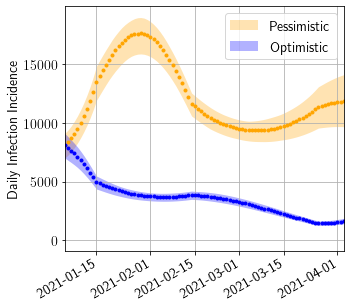

In [7]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize = (5,5), sharex=True, facecolor = 'white')#, sharey=True)

idsim = 102



#ax.plot(all_compU.index,
#        all_compU.median(axis=1), 
#        linestyle='-', 
#        lw = 2,
#        color = 'orange'
#       )
#ax.plot(all_compL.index,
#        all_compL.median(axis=1), 
#        linestyle='-', 
#        lw = 2,
#       color = 'blue')

ax.fill_between(all_compU.index,
                all_compU.quantile(.025, axis=1),
                all_compU.quantile(.975, axis=1),
                linestyle='-', lw = 0,
                label = 'Pessimistic',
                alpha = .3,
                color = 'orange')
ax.fill_between(all_compL.index,
                all_compL.quantile(.025, axis=1),
                all_compL.quantile(.975, axis=1),
                linestyle='-', 
                label = 'Optimistic',
                lw = 0,
                alpha = .3,
                color = 'blue')

ax.plot(all_compU.index,all_compU[idsim], 
        linestyle='',
        marker='.', 
        #label = 'Pessimistic',
        color = 'orange')
ax.plot(all_compL.index,all_compL[idsim], 
        linestyle='',
        marker='.', 
        #label = 'Optimistic',
        color = 'blue')

#ax.set_title(nname)
ax.set_xlim(setup.start_date+datetime.timedelta(1), setup.end_date)
ax.set_ylabel('Daily Infection Incidence', fontsize=14)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.grid()
fig.autofmt_xdate()
fig.savefig('figures/infection_scenarios.pdf')

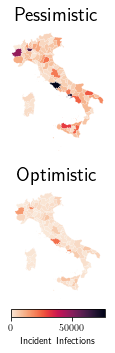

In [11]:
s = all_sims['U'][idsim-1]
sU = s[s['comp'] == 'yell']
s = all_sims['L'][idsim-1]
sL = s[s['comp'] == 'yell']

resU = setup.shp.copy()
resL = setup.shp.copy()

for i, node in enumerate(setup.ind2name):
    mdp = sL[sL['place']==node]
    new_inf    = mdp[mdp['comp']=='yell']['value'].sum() 
    resL.loc[i, 'new_inf'] =    new_inf
    resL.loc[i, 'new_inf_pop'] =    new_inf/setup.pop_node[i]
    mdp = sU[sU['place']==node]
    new_inf  = mdp[mdp['comp']=='yell']['value'].sum() 
    resU.loc[i, 'new_inf'] =    new_inf
    resU.loc[i, 'new_inf_pop'] = new_inf/setup.pop_node[i]

fig, axes = plt.subplots(2,1, figsize=(1.7, 5))
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = sns.cm.rocket#  'OrRd'
vmin = 0
vmax = max(resU['new_inf'])
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []


ax=axes.flat[0]
res = resU
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("bottom", size="5%", pad=0.1)
mp = res.plot(ax = ax, column='new_inf', cmap='rocket_r', vmin = 0, vmax = vmax, lw = .1, edgecolor="white",# legend=True, 
              legend_kwds={'label': 'Total Incident Infections',     'orientation': "horizontal"})
ax.set_title('Pessimistic', fontsize=20)
ax.axis('off')

ax=axes.flat[1]
res = resL
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="7%", pad=0.01)
mp = res.plot(ax = ax, column='new_inf', cmap='rocket_r', vmin = vmin, vmax = vmax, lw = .1, edgecolor="white", cax = cax, legend=True, 
              legend_kwds={'label': 'Incident Infections', 
                          # 'labelsize':16,
                           'orientation': "horizontal"})

#cb_ax = fig.axes[2] 
#cb_ax.tick_params(labelsize=20)
#cb_ax.set_title('New infections', fontsize=15)
ax.set_title('Optimistic', fontsize=20)
ax.axis('off');
fig.tight_layout()
fig.savefig('figures/infection_scenarios_map.pdf')

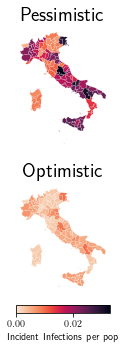

In [14]:
fig, axes = plt.subplots(2,1, figsize=(1.7, 5))
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = sns.cm.rocket#  'OrRd'
vmin = 0
vmax = max(resU['new_inf_pop'])
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []


ax=axes.flat[0]
res = resU
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("bottom", size="5%", pad=0.1)
mp = res.plot(ax = ax, column='new_inf_pop', cmap='rocket_r', vmin = 0, vmax = vmax, lw = .1, edgecolor="white",# legend=True, 
              legend_kwds={'label': 'Total Incident Infections',     'orientation': "horizontal"})
ax.set_title('Pessimistic', fontsize=20)
ax.axis('off')

ax=axes.flat[1]
res = resL
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="7%", pad=0.01)
mp = res.plot(ax = ax, column='new_inf_pop', cmap='rocket_r', vmin = vmin, vmax = vmax, lw = .1, edgecolor="white", cax = cax, legend=True, 
              legend_kwds={'label': 'Incident Infections per pop', 
                          # 'labelsize':16,
                           'orientation': "horizontal"})

#cb_ax = fig.axes[2] 
#cb_ax.tick_params(labelsize=20)
#cb_ax.set_title('New infections', fontsize=15)
ax.set_title('Optimistic', fontsize=20)
ax.axis('off');
fig.tight_layout()
fig.savefig('figures/infection_scenarios_map_pop.pdf')

In [58]:
idpick = idsim-1
yell_U = all_sims['U'][idpick]
yell_L = all_sims['L'][idpick]

In [59]:
both_res = []

for md in [yell_L, yell_U]:
    res = setup.shp.copy()
    for i, node in enumerate(setup.ind2name):

        mdp = md[md['place']==node]

        total_vacc = mdp[ mdp['comp']=='vacc']['value'].sum()
        ndays_vacc = len(mdp[(mdp['comp']=='vacc') & (mdp['value']>1)])
        total_inf  = mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (mdp.index == str(setup.end_date))]['value'].sum()
        new_inf    = mdp[ mdp['comp']=='yell']['value'].sum() # mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A']) & (mdp.index == str(setup.end_date))]['value'].sum()

        res.loc[i, 'total_vacc'] = total_vacc
        res.loc[i, 'ndays_vacc'] = ndays_vacc
        res.loc[i, 'total_inf'] =  total_inf
        res.loc[i, 'new_inf'] =    new_inf
        res.loc[i, 'new_inf_pop'] =    new_inf/ setup.pop_node[i]
        res.loc[i, 'population'] = setup.pop_node[i] # overwrite
    both_res.append(res)

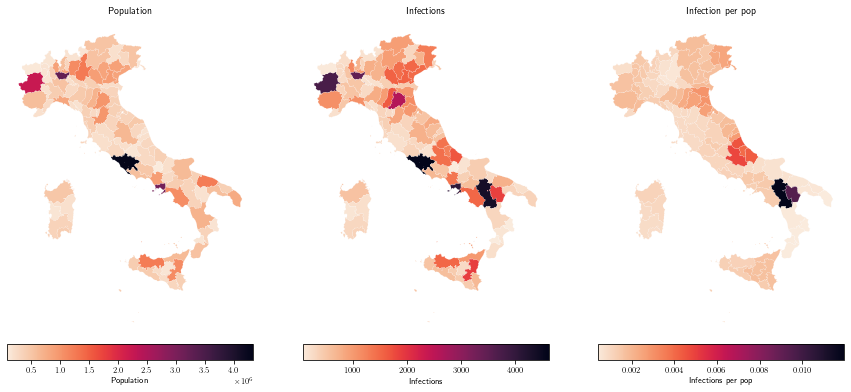

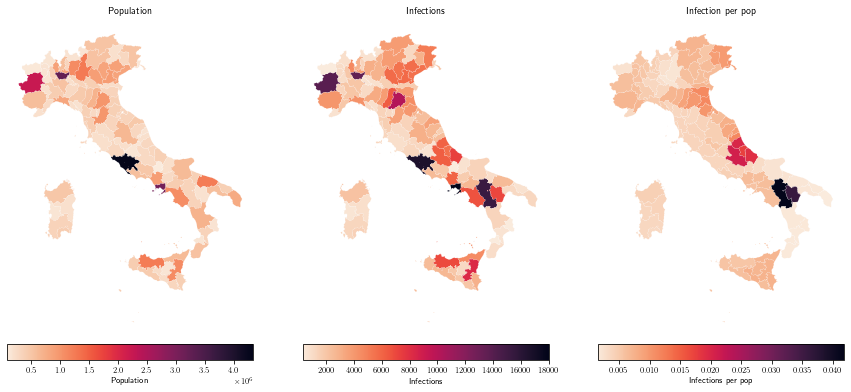

In [60]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

for res in both_res:
    fig, axes = plt.subplots(1,3, figsize=(15, 10))

    plt_infos = {'population': 
                 {'legend':'Population',
                  'title': 'Population'},
                'new_inf': 
                 {'legend':'Infections',
                  'title': 'Infections'},
                'new_inf_pop': 
                 {'legend':'Infections per pop',
                  'title': 'Infection per pop'}}


    for i, (colname, details) in enumerate(plt_infos.items()):
        ax=axes.flat[i]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="5%", pad=0.1)
        mp = res.plot(ax = ax, column=colname, cmap='rocket_r', lw = .1, edgecolor="white", cax = cax, legend=True, legend_kwds={'label': details['legend'],     'orientation': "horizontal"})
        ax.set_title(details['title'])
        ax.axis('off')
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)

I


NameError: name 'scenarios' is not defined

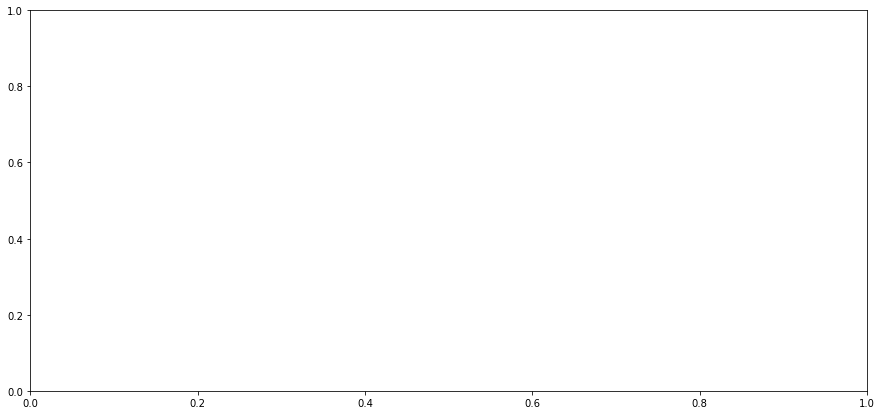

In [24]:
fig, axes = plt.subplots(1,1, figsize = (15,7), facecolor = 'white')
i = 3
st = states_names[i]
print(st)

for scn in scenarios:
    md = mydata[scn]
    axes.plot(md[(md['comp'] == st)].groupby('date').sum()['value'], linestyle='-', lw = 2, label = scn)
axes.set_title(st)
    
axes.legend()
fig.autofmt_xdate()

In [ ]:
md[(md['comp'] == st)].groupby('date').sum()['value']

In [ ]:
fig, axes = plt.subplots(5,22, figsize = (30,15), sharex=True, facecolor = 'white')#, sharey=True)
i = 3
st = states_names[i]
print(st)
for k, nname in enumerate(setup.ind2name):
    for scn in scenarios:
        md = mydata[scn]
        axes.flat[k].plot(md[(md['comp'] == st) & (md['placeID'] == k)]['value'], linestyle='-', lw = 2, label = scn)
    axes.flat[k].set_title(nname)
    
axes.flat[0].legend()
fig.autofmt_xdate()

In [ ]:
import scipy
course = scipy.interpolate.interp1d([0, 50, 100, 1000], [.75, .85, .45,.45], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100], [.75, .85, .45], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100], [1.3, .7, 2], kind='quadratic')
course = course(np.arange(0, setup.ndays))
plt.plot(course)

In [ ]:
course = scipy.interpolate.interp1d([0, 50, 100, 100000], [1.3, .7, 2, 2], kind='linear')
course = course(np.arange(0,  250))
plt.plot(course)